# Required assignment 7.1: Applying predictive modelling techniques to real-world data

The goal of this assignment is to predict whether someone’s salary is above or below $50,000 a year based on a publicly available data set of census data. The original data set can be found on the UCI repository: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
#Import the packages
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt

### Read the file

In [3]:
#Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/
#Taken and modified slightly from https://fairmlbook.org/code/adult.html

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] #Features of the data set

#Change these to local files if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data' #Link of the training data
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' #Link of the test data

#This will download 3.8M
df_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*',
                             engine='python', na_values="?") #Read CSV training
#This will download 1.9M
df_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*',
                            engine='python', na_values="?", skiprows=1) #Read CSV test

num_train = len(df_train) #Number of training instances

Replace the labels of the training and test sets so that 'Target = 1' means high income and 'Target = 0' means low income. The target column should be an integer (binary) column eventually.

In [4]:
#First, list the possible training values
print("Unique values in training set target", df_train.Target.unique())
print("Unique values in test set target", df_test.Target.unique())

Unique values in training set target ['<=50K' '>50K']
Unique values in test set target ['<=50K.' '>50K.']


In [5]:
#Now you can replace the labels
df_train.Target = df_train.Target.replace('<=50K', 0).replace('>50K', 1)
df_test.Target = df_test.Target.replace('<=50K.', 0).replace('>50K.', 1)


### Question 1:
The columns' names and data types are inspected. The missing values in the training and test sets in each column are listed. Find the number of missing values in both the training and testing data sets.

The columns are listed first.

#### Q1.1: List how many missing values there are in each column for the training and test sets.

Compute the number of missing rows in the training data set and assign it to `missing_train`.

Compute the rows in the training data set with at least one `NaN` and assign it to  `missing_train_NaN`. Divide `missing_train` by `missing_train_NaN` and assign it to `result1`.

Compute the number of missing rows in the testing data set and assign it to `missing_test`.
Compute the rows in the testing data set with at least one `NaN` and assign it to  `missing_test_NaN`. Divide `missing_test` by `missing_test_NaN` and assign it to `result2`.

Hint: To compute `missing_train_NaN`, compute the missing rows with at least one `NaN`. This can be done by using `.any(axis=1)`.

To find the sum, use `np.sum()`.

In [6]:
#First, list the columns
pd.set_option('max_colwidth', None)
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Martial Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
###GRADED CELL
missing_train = None
missing_train_NaN = None
result1 = None
missing_test = None
missing_test_NaN = None
result2 = None

# YOUR CODE HERE
#raise NotImplementedError()

#total number of missing values
missing_train = np.sum(df_train.isna().sum())
missing_test = np.sum(df_test.isna().sum())

#number of rows that have at least one missing value
missing_train_NaN = np.sum(df_train.isna().any(axis=1))
missing_test_NaN = np.sum(df_test.isna().any(axis=1))

#ratio of missing values per missing row
result1 = missing_train / missing_train_NaN if missing_train_NaN > 0 else 0
result2 = missing_test / missing_test_NaN if missing_test_NaN > 0 else 0

print("Ratio for training data set  " , result1)
print("Ratio for testing data set ", result2)

Ratio for training data set   1.7765735723218008
Ratio for testing data set  1.8042588042588044


### Question 2:
The target variable is further investigated.

#### Q2.1: What fraction of the target is in the training and testing data sets?

Assign the values to `training_target` and `testing_target`, respectively.

Hint: Use `.value_counts(normalize = True)`.

In [8]:
###GRADED CELL
training_target = None
testing_target = None

# YOUR CODE HERE
#raise NotImplementedError()

#proportion of class 0 (≤50K) vs class 1 (>50K) in the training set
training_target = df_train["Target"].value_counts(normalize=True)
testing_target = df_test["Target"].value_counts(normalize=True)

print("The target counts in the training set is given by ",training_target)
print("The target counts in the testing set is given by", testing_target)

The target counts in the training set is given by  Target
0    0.75919
1    0.24081
Name: proportion, dtype: float64
The target counts in the testing set is given by Target
0    0.763774
1    0.236226
Name: proportion, dtype: float64


If you classify everyone as a low-income instance, the accuracy, sensitivity and specificity in the test set can be evaluated by considering the high-income class as the positive class, since your goal is to identify individuals who make more money.

In [9]:
# Accuracy: fraction of true 0's over all test samples
accuracy = len(df_test[df_test['Target'] == 0]) / len(df_test)

# Sensitivity (recall for class 1): always predicting 0 → never detect 1s
sensitivity = 0 #You never said '1', so you cannot classify any 1s correctly

# Specificity (recall for class 0): always predicting 0 → catch all 0s
specificity = 1 #You say '0' to all instances, so you cannot miss any 0s

print("Baseline always-0 classifier:")
print("Accuracy:", round(accuracy, 3))
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Baseline always-0 classifier:
Accuracy: 0.764
Sensitivity: 0
Specificity: 1


#### Q2.2: List the fraction of high-income instances within each group of 'work class' separately in the training set.

Assign the output to `workclass`.

Hint: Use `.groupby(..., as_index=False)['Target'].mean()` to compute the fraction of high-income earners, then use `.sort_values(by='Target')` to sort by the resulting fraction.

In [10]:
###GRADED CELL
#First, group by work classes, take the target, average it and then print it in an ascending way.
workclass = None

# YOUR CODE HERE
#raise NotImplementedError()

#fraction of high-income earners per workclass
workclass = (
    df_train.groupby("Workclass", as_index=False)["Target"]
    .mean()
    .sort_values(by="Target", ascending=True)
)

print(workclass)

          Workclass    Target
2      Never-worked       0.0
7       Without-pay       0.0
3           Private  0.218673
6         State-gov  0.271957
5  Self-emp-not-inc  0.284927
1         Local-gov  0.294792
0       Federal-gov  0.386458
4      Self-emp-inc  0.557348


#### Q2.3: Building on the previous question, apply the following simple classification rule to the test set: classify an instance as '1' (high income) if its work class belongs to one of the two highest-earning groups.

Using the confusion matrix, calculate and report the accuracy and sensitivity of this model.

Compute accuracy and assign it to `accuracy`. Accuracy can also be computed as a fraction of the correct values within the total values.
Compute sensitivity and assign it to `sensitivity`.

Hint: Sensitivity = $$ \frac{TP}{TP + FN} $$

In [11]:
greedy_workclass = df_test.apply(lambda row: 1 if (row["Workclass"] == "Self-emp-inc") or\
                                 (row["Workclass"] == "Federal-gov") else 0, axis = 1) #apply the function to predict

In [12]:
#Import sklearn's confusion matrix
from sklearn.metrics import confusion_matrix

# Ensure both inputs are of integer type (0 or 1)
cm = confusion_matrix(df_test.Target.astype(int), greedy_workclass.astype(int))

In [13]:
###GRADED CELL
total = len(df_test.Target)
correct = cm[0][0] + cm[1][1]
accuracy = None
sensitivity = None

# YOUR CODE HERE
#raise NotImplementedError()

accuracy = correct / total
sensitivity = cm[1][1] / (cm[1][0] + cm[1][1]) if (cm[1][0] + cm[1][1]) > 0 else 0.0

print("The accuracy is given by ", accuracy)
print("The sensitivity is given by ", sensitivity)

The accuracy is given by  0.7613782937166022
The sensitivity is given by  0.1315652626105044


### Question 3: Performing further statistics and outlier detection

#### Q3.1: List the fraction of male and female US citizens in the training set.

Assign the answer to `US_Gender`.

Hint: Use country = 'United-States' and compute the `.value_counts(normalize = True)` on the 'Sex' attribute.

In [14]:
###GRADED CELL

US_Gender = None

# YOUR CODE HERE
#raise NotImplementedError()

#computing the gender distribution among U.S. citizens in the training set
US_Gender = df_train[df_train["Country"] == "United-States"]["Sex"].value_counts(normalize=True)

print("The gender distribution is given by ",US_Gender)

The gender distribution is given by  Sex
Male      0.668084
Female    0.331916
Name: proportion, dtype: float64


#### Q3.2: What is the most common occupation in the training set?

Assign the answer to `occupation`. Use `.idxmax()` to get the most common occupation.

In [15]:
###GRADED CELL
occupation = None

# YOUR CODE HERE
#raise NotImplementedError()

#finding the most common occupation in the training dataset
occupation = df_train["Occupation"].value_counts().idxmax()

print(occupation)

Prof-specialty


#### Q3.3: Which occupations are the most common among male and female US citizens, respectively, in the training set?

Assign your answers to `occupation_male` and `occupation_female`.

In [16]:
###GRADED CELL
occupation_male = None
occupation_female = None

# YOUR CODE HERE
#raise NotImplementedError()

#most common occupation among males and females respectively
occupation_male = df_train[df_train["Sex"] == "Male"]["Occupation"].value_counts().idxmax()
occupation_female = df_train[df_train["Sex"] == "Female"]["Occupation"].value_counts().idxmax()

print("The most common male occupation is ", occupation_male)
print("The most common female occupation is", occupation_female)

The most common male occupation is  Craft-repair
The most common female occupation is Adm-clerical


Plotting the histogram of the 'Age' column using the training data set, setting it to ten bins and reflecting the percentage of instances on the Y-axis, allows for visually assessing potential outliers, indicating whether they are more prevalent at the higher or lower end of the age range.

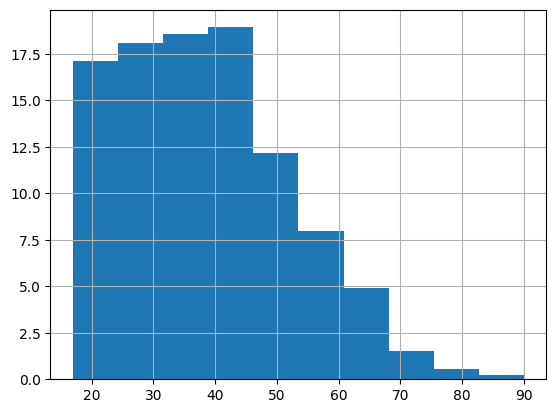

In [17]:
df_train["Age"].hist(bins=10, weights=np.ones_like(df_train["Age"]) * 100. / len(df_train)).plot()
plt.show()
plt.close()

The age on the $99th$ quantile is 74. So, it is not an erroneous outlier.

In [18]:
df_train["Age"].quantile(0.99) #The ``.quantile`` function of pandas DataFrame

74.0

The correlation analysis in the training set shows that among the numerical predictors, 'Education-Num' and 'Age' have the strongest positive correlations with the target variable. The correlation of 'Age' with the target indicates a moderate positive relationship, suggesting that as age increases, the likelihood of belonging to the positive class (high income) tends to increase.

In [19]:
numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()
if 'Target' in numerical_cols:
  numerical_cols.remove('Target')
df_train[numerical_cols].corrwith(df_train["Target"], method = 'pearson')

Age               0.234037
fnlwgt           -0.009463
Education-Num     0.335154
Capital Gain      0.223329
Capital Loss      0.150526
Hours per week    0.229689
dtype: float64

### Question 4: Applying the linear regression model for classification

Linear regression, as the name suggests, is a regression method, but you would like to apply classification. For that, the `NaN` values are first removed. A copy of `df_train()` is made, and `.dropna()` is used to drop `NaN` values.

In [ ]:
df_save = df_train.copy()

In [ ]:
df_train = df_train.dropna(how='any')

#### Q4.1: Train a linear regression model on the training set.

This has two steps. In step 1, the numeric columns are picked and stored in the array `numericals`. In the step 2, `LinearRegression()`is fitted using `.fit(X,y)`.

Hint: The input `X` and the output `y` are picked from `df_train` numerical inputs and the target.
The model is assigned to `clf`.

In [21]:
#Step 1: take the numeric columns
numericals = [] #Start with an empty array
for i in range(len(df_train.dtypes)): #For all columns
    coltype = df_train.dtypes.iloc[i] #Take the type of column
    if coltype != 'object' and df_train.columns[i] != 'Target': #Object types are the categorical variables
        numericals.append(df_train.columns[i])

In [22]:
###GRADED CELL
#Step 2: fit
from sklearn.linear_model import LinearRegression
X = None
y = None
clf = None

# YOUR CODE HERE
#raise NotImplementedError()

#Fit Linear Regression
X = df_train[numericals]   # Training predictors
y = df_train["Target"]     # Training target
clf = LinearRegression().fit(X, y)   # Tnow contains the trained linear regression model


#### Q4.2: Apply the linear model that you just fitted and predict the training target. Show the first five predictions.

Use `.predict(X)` and assign the result to `scores_linear_training`.

In [23]:
###GRADED CELL

scores_linear_training = None

# YOUR CODE HERE
#raise NotImplementedError()

#use the trained linear regression model (clf) to make predictions on the training data
scores_linear_training = clf.predict(X)

print(scores_linear_training[:5])

[0.36524015 0.265893   0.16659351 0.16826609 0.29973767]


To perform classification on the training set, apply a cut-off value of 0.4 such that any predicted output greater than this threshold is classified as '1' (positive class) and otherwise as '0' (negative class). Then, manually compute the accuracy, sensitivity and specificity using the confusion matrix components without relying on built-in functions. Finally, analyse and discuss the model’s performance based on these metrics.

In [24]:
cutoff = 0.4 #Cut-off value
predicted_linear_training = (scores_linear_training >= cutoff) #Take the scores, and apply the logical

In [25]:
predicted_linear_training[:9] #Here are some of the classifications

array([False, False, False, False, False, False, False, False,  True])

In [26]:
def metrics(cm): #This function returns relevant statistics
    total = cm[0][0] + cm[1][1] +  cm[0][1] +  cm[1][0]
    correct = cm[0][0] + cm[1][1]
    accuracy = correct/total
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    return total, correct,accuracy,specificity,sensitivity

In [27]:
total_train, correct_train,accuracy_train,specificity_train,sensitivity_train \
= metrics(confusion_matrix(df_train.Target.astype(int), predicted_linear_training.astype(int))) #get all the metrics

In [28]:
print("Accuracy:", round(accuracy_train,3), "\nSensitivity:", round(sensitivity_train,3),\
      "\nSpecificity:", round(specificity_train,3))

Accuracy: 0.802 
Sensitivity: 0.464 
Specificity: 0.909


Observation:
- Accuracy is 79.6 per cent, which is better than the 75 per cent accuracy you can obtain if you say '0' to all.
- Sensitivity is 47.9 per cent, which is better than the 24 per cent sensitivity you can obtain if you say '1' to all.
- Both metrics improve the greedy method you applied.

#### Q4.3: Apply the same on the training set but decrease the cut-off value down to 0.2. Inspect the metrics you looked at before and compare the results with the 0.4 cut-off. Interpret the results.

Use the `metrics()` defined above. The accuracy, sensitivity and specificity are computed storing in `_,_,accuracy_train_alt,specificity_train_alt,sensitivity_train_alt`.

Use `cm_alt` to store the `confusion_matrix` of `df_train.Target.astype(int)` and `predicted_linear_training_alternative`.

In [29]:
###GRADED CELL
_, _, accuracy_train_alt, specificity_train_alt, sensitivity_train_alt = None, None, None, None, None
cutoff_alternative = 0.2  # Cut-off value
predicted_linear_training_alternative = (scores_linear_training >= cutoff_alternative)
predicted_linear_training_alternative = predicted_linear_training_alternative.astype(int)
cm_alt = None

# YOUR CODE HERE
#raise NotImplementedError()

#Repeat with a lower cutoff (0.2)
from sklearn.metrics import confusion_matrix

# build confusion matrix at cutoff = 0.2
cm_alt = confusion_matrix(df_train.Target.astype(int), predicted_linear_training_alternative.astype(int))

# compute metrics
_, _, accuracy_train_alt, specificity_train_alt, sensitivity_train_alt = metrics(cm_alt)

print("Accuracy:", round(accuracy_train_alt,3),
      "\nSensitivity:", round(sensitivity_train_alt,3),
      "\nSpecificity:", round(specificity_train_alt,3))


Accuracy: 0.625 
Sensitivity: 0.888 
Specificity: 0.542


In [30]:
print("Accuracy:", round(accuracy_train_alt,3), "\nSensitivity:", round(sensitivity_train_alt,3),\
      "\nSpecificity:", round(specificity_train_alt,3))

Accuracy: 0.625 
Sensitivity: 0.888 
Specificity: 0.542


Observation:
- By lowering the cut-off value to 0.2, the model exhibits improved sensitivity at the expense of reduced specificity. This adjustment results in capturing more positive cases (increased true positives) but also leads to a higher false positive rate. Consequently, while sensitivity improves, specificity declines, and the overall accuracy may vary depending on the trade-offs.

When applying a higher cutoff value of 0.4 on the test set, the accuracy, sensitivity, and specificity metrics are recalculated based on the predicted classifications derived from the confusion matrix.

In [34]:
X_test = df_test[numericals] #Extract predictors
y_test = df_test.Target #Same for the test target
cutoff_test = 0.4
scores_linear_test = clf.predict(X_test)
predicted_linear_test = (scores_linear_test >= cutoff_test)

In [35]:
_, _,accuracy_test,specificity_test,sensitivity_test \
= metrics(confusion_matrix(df_test.Target.astype(int), predicted_linear_test.astype(int))) #Get all the metrics

In [36]:
print("Accuracy:", round(accuracy_test,3), "\nSensitivity:", round(sensitivity_test,3),\
      "\nSpecificity:", round(specificity_test,3))

Accuracy: 0.798 
Sensitivity: 0.46 
Specificity: 0.903


In the previous question, you tuned the cut-off value on the training set. This initially makes sense because you cannot tune on the test set, which would mean indirectly training on the same test set. However, you also saw in the validation set approach that it is not good practice to compare models on the training set because of a natural bias in that procedure. Hence, it is a better approach to tune a value on a validation set. For this purpose, apply the following steps:

- Split the training set as 80 per cent training and 20 per cent validation sets. You can take the first 80 per cent and the last 20 per cent — there's no need to randomise the selection.

- Train a linear model on the training set obtained in the previous approach. Training one model is enough.

- Compare cut-off values between 0.2–0.8 with 0.05 increments. Pick the best model by looking at the validation set, where the best model has an accuracy over 76 per cent while still having the highest sensitivity.

- Test the validated cut-off on the test set and return the metrics.

- Extra/optional: Instead of the hold-out validation you just applied, try five-fold cross-validation in the original training set.

In [37]:
# Step 1: split
training_nr = round(len(X)*0.8)
train_80 = X[:training_nr]
y_train_80 = df_train[:training_nr].Target #Training target
validate_20 = X[training_nr:]
y_validate_20 = df_train[training_nr:].Target #Training target

In [38]:
# Step 2: train
clf = LinearRegression().fit(train_80, y_train_80) #Time to fit

In [39]:
# Step 3: try cut-offs
scores_linear_validation = clf.predict(validate_20) #Predict
cutoffs = np.arange(0.2,0.85, 0.05)
max_cutoff = 0
max_sensitivity = 0
for cutoff in cutoffs:
    predicted_linear_validated = (scores_linear_validation >= cutoff)
    _, _,accuracy_validate,specificity_validate, sensitivity_validate \
        = metrics(confusion_matrix(y_validate_20.astype(int), predicted_linear_validated.astype(int))) #Get all the metrics
    if accuracy_validate >= 0.76 and sensitivity_validate >= max_sensitivity:
        max_cutoff = cutoff
        max_sensitivity = sensitivity_validate
        max_accuracy = accuracy_validate

In [40]:
print("The best cutoff value is", max_cutoff, "with a validation accuracy of", round(max_accuracy,3), \
      "and a validation sensitivity of", round(max_sensitivity,3))

The best cutoff value is 0.3 with a validation accuracy of 0.761 and a validation sensitivity of 0.712


In [41]:
#Step 4: test this
scores_validated_test = clf.predict(X_test)
predicted_validated_test = (scores_validated_test >= max_cutoff)
_, _,accuracy_test,specificity_test,sensitivity_test \
    = metrics(confusion_matrix(df_test.Target.astype(int), predicted_validated_test.astype(int))) #get all the metrics
print("Accuracy:", round(accuracy_test,3), "\nSensitivity:", round(sensitivity_test,3),\
      "\nSpecificity:", round(specificity_test,3)) #You are done!

Accuracy: 0.748 
Sensitivity: 0.681 
Specificity: 0.769


### Final notes
Linear regression is not inherently suited for classification tasks, but it can perform reasonably well in some cases. Logistic regression, a related method, models a linear relationship like linear regression but applies a non-linear transformation to produce outputs between 0 and 1. This allows straightforward classification by assigning instances with predicted values ≥ 0.5 to class '1', with the threshold adjustable as needed.

In [42]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X, y.astype(int))

In [43]:
scores_linear_training = clf.predict(X)

In [44]:
total_train, correct_train,accuracy_train,specificity_train,sensitivity_train \
= metrics(confusion_matrix(df_train.Target.astype(int), scores_linear_training.astype(int)))